In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


## Solver

In [108]:
import numpy as np

def solve(original, transformed):
    
    # checking dimensions
    assert(original.shape[1] == 2)
    assert(transformed.shape[1] == 2)
    assert(transformed.shape[0] == original.shape[0])
    
    matches_count = original.shape[0]
    zeros = np.zeros((matches_count, 3))
    coordinates_with_1 = np.append(original, np.ones((matches_count,1)), axis=1)
    x_left = np.column_stack((coordinates_with_1, zeros)).reshape(2 * matches_count, 3)
    x_right = np.column_stack((zeros, coordinates_with_1)).reshape(2 * matches_count, 3)
    x = np.column_stack((x_left, x_right)).astype(int)
    y = transformed.reshape((2*matches_count, 1))
    
    # solving the system
    first_term = x.transpose().dot(x)
    second_term = x.transpose().dot(y)
    a = np.linalg.inv(first_term).dot(second_term)
    return a
    

def test1():
    # test scaling
    original = np.array([1,2,3,1,5,6]).reshape(3,2)
    print(original)
    transformed = original * 2
    print(transformed)
    a = solve(original, transformed)
    print(a.astype(int))
    assert(np.array_equal(np.array(a - np.array([2,0,0,0,2,0]).reshape(6,1)).astype(int), np.zeros((6,1))))
    
def test2():
    # test translation
    original = np.array([1,2,3,1,5,6]).reshape(3,2)
    print(original)
    transformed = original + 3
    print(transformed)
    a = solve(original, transformed)
    print(a.astype(int))
    assert(np.array_equal(np.array(a - np.array([1,0,3,0,1,3]).reshape(6,1)).astype(int), np.zeros((6,1))))
    
def test3():
    # test rotation
    x = np.array([1,5,2])
    y = np.array([2,5,8])
    angle = np.pi/4.
    x_rotated = x*np.cos(angle) - y*np.sin(angle)
    y_rotated = x*np.sin(angle) + y*np.cos(angle)
    original = np.column_stack((x,y))
    transformed = np.column_stack((x_rotated, y_rotated))
    print('original:', original)
    print('transformed:', transformed)
    a = solve(original, transformed)
    print(a.astype(int))
    
    
def main():
    test1()
    test2()
    test3()
    
main()

[[1 2]
 [3 1]
 [5 6]]
[[ 2  4]
 [ 6  2]
 [10 12]]
[[2]
 [0]
 [0]
 [0]
 [2]
 [0]]
[[1 2]
 [3 1]
 [5 6]]
[[4 5]
 [6 4]
 [8 9]]
[[1]
 [0]
 [3]
 [0]
 [1]
 [3]]
original: [[1 2]
 [5 5]
 [2 8]]
transformed: [[-7.07106781e-01  2.12132034e+00]
 [ 4.44089210e-16  7.07106781e+00]
 [-4.24264069e+00  7.07106781e+00]]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]]


## SIFT

In [1]:
import cv2
sift = cv2.xfeatures2d.SIFT_create()
import numpy as np

gray = cv2.imread('input/frames/rotate/frame1.jpg', 0)
# gray= cv2.cvtColor(img ,cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT()
kp = sift.detect(gray,None)

img=cv2.drawKeypoints(gray,kp)

cv2.imwrite('sift_keypoints.jpg',img)

error: OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1207: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'


## Transform

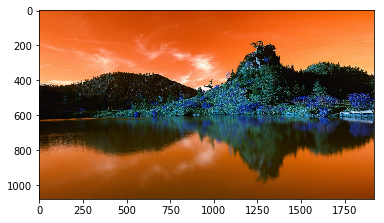

[[ -83.33333333   66.66666667]
 [1068.66666667 1986.66666667]
 [1284.66666667 -293.33333333]
 [2436.66666667 1626.66666667]]


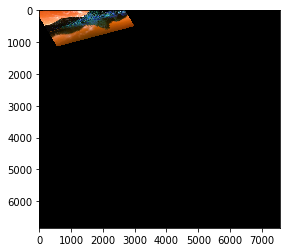

In [39]:
# Transforming

import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread('../input/target.jpg', 1)
plt.imshow(img)
# plt.imshow(img)
plt.show()


rows, cols, ch = img.shape

pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])
M = cv2.getAffineTransform(pts1,pts2)
# print(M.shape)

affine_matrix = np.array([2.,0.,0.,0.,2.,0.]).reshape((2,3))

affine_matrix = M

limits = np.array([[0,0,1],[0,cols,1],[rows,0,1],[rows,cols,1]])
transformed_limits = limits.dot(affine_matrix.transpose())
print(transformed_limits)
max_limits = np.amax(transformed_limits, axis=0)
min_limits = np.amin(transformed_limits, axis=0)
dst_cols = max_limits[0] - min_limits[0]
dst_rows = max_limits[1] - min_limits[1]
dst = cv2.warpAffine(img, affine_matrix, (dst_cols.astype(int)*3, dst_rows.astype(int)*3))

plt.clf()
plt.imshow(dst)
plt.show()

## ORB



In [174]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.30

s_img = cv2.imread("../input/target.jpg", 1)

# initialize with target image artificially positioned
s_img = cv.resize(s_img, (500, 360), interpolation = cv.INTER_CUBIC)

# this will only the binary mask
frame = cv2.imread("../input/frames/rotate/frame1.jpg", cv2.IMREAD_COLOR)
mask = np.zeros((frame.shape[0], frame.shape[1]), np.uint8)
print('s_img shape:', s_img.shape)
mask[190:(190+s_img.shape[0]),330:(330+s_img.shape[1])] = 1

# this will contain the target image
target = np.zeros((frame.shape[0], frame.shape[1], 3), np.uint8)
target[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img


def getAffineTransform(original, transformed):
    """
    Finds the affine transformation based on pixel coordinates.
    This is all based on the linear equation provided in the Project 2 PDF
    :param original: array (M x 2) containing the coordinates in the original image - one coordinate [x,y] per row
    :param transformed: array (M x 2) containing the coordinates in the transformed image - one coordinate [x,y] per row
    :return: matrix A that defines the affine transformation
    """

    # checking dimensions
    assert (original.shape[1] == 2)
    assert (transformed.shape[1] == 2)
    assert (transformed.shape[0] == original.shape[0])

    # building the X matrix
    matches_count = original.shape[0]
    zeros = np.zeros((matches_count, 3))
    coordinates_with_1 = np.append(original, np.ones((matches_count, 1)), axis=1)
    x_left = np.column_stack((coordinates_with_1, zeros)).reshape(2 * matches_count, 3)
    x_right = np.column_stack((zeros, coordinates_with_1)).reshape(2 * matches_count, 3)
    x = np.column_stack((x_left, x_right)).astype(int)

    # building the Y matrix
    y = transformed.reshape((2 * matches_count, 1))

    # solving the system
    first_term = x.transpose().dot(x)
    second_term = x.transpose().dot(y)
    a = np.linalg.inv(first_term).dot(second_term)
    return a.reshape(2,3)


    

def alignImages(im1, im2):
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
    
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # add green circles on keypoints
#     for p in points1:
# cv.circle(im1, (p[0], p[1]), 5, (0,255,0), -1)
    corners = np.zeros((len(keypoints1), 2), dtype=np.float32)
    for i, p in enumerate(keypoints1):
        cv2.circle(im1, (int(p.pt[0]), int(p.pt[1])), 5, (0,255,0), -1)
        corners[i, :] = p.pt
    
#     corners.sort()
#     print('corners:')
#     print(corners)
        
    # Compute affine transformation matrix and Transform
    cols, rows = im2Gray.shape
    affine_transform = getAffineTransform(points1, points2)
    print(affine_transform.shape)
    dst = cv2.warpAffine(im1, affine_transform, (rows, cols))

    # 190 330
    # 185 827
    # 547 831
    # 330 530
    
    # frame 1 
    global s_img, mask, target
    l_img = im1
    x_offset=330
    y_offset=190
#     s_img = cv2.warpAffine(s_img, affine_transform, (300, 400))
#     l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
#     plt.imshow(l_img)
#     plt.show()
#     plt.clf()
    
    # frame 2 - transform
    l_img = im2
    s_img = cv2.warpAffine(s_img, affine_transform, (500, 360))
#     l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img

#     pasted = np.copy(mask)
#     pasted = cv2.bitwise_not(l_img, pasted, mask)
    mask = cv2.warpAffine(mask, affine_transform, (mask.shape[1], mask.shape[0]))
    target = cv2.warpAffine(target, affine_transform, (mask.shape[1], mask.shape[0]))
#     pasted = cv2.bitwise_not(im2, pasted, mask)
    copy_output = np.copy(im2)
    np.copyto(copy_output, target, where=mask[:, :, None].astype(bool))
    
#     plt.imshow(mask), plt.title('Mask'), plt.show(), plt.clf()
#     plt.imshow(copy_output), plt.title('Frame 2'), plt.show(), plt.clf()
    
    return copy_output


if __name__ == '__main__':
    FRAMES = 1000
    for i in range(FRAMES):
        try:
            # Read reference image
            refFilename = "../input/frames/scale/frame"+str(i)+".jpg"
            print("Reading reference image : ", refFilename)
            imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

            # Read image to be aligned
            imFilename = "../input/frames/scale/frame"+str(i+1)+".jpg"
            print("Reading image to align : ", imFilename);  
            im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

            print("Aligning images ...")
            # Registered image will be resotred in imReg. 
            # The estimated homography will be stored in h. 
            pasted = alignImages(imReference, im)

            # Write aligned image to disk. 
            outFilename = "scale"+str(i)+".jpg"
            print("Saving aligned image : ", outFilename); 
            cv2.imwrite(outFilename, pasted)
            
        except:
            break
    
    height,width,layers=img[1].shape
    video = cv2.VideoWriter('scale.avi',cv2.VideoWriter_fourcc(*"MJPG"), 30,(width,height))

    for i in range(FRAMES):
        video.write(cv2.imread('scale'+ str(i)+'.jpg'))

    cv2.destroyAllWindows()
    video.release()
    
        # Print estimated homography
#         print("Estimated homography : \n",  h)

s_img shape: (360, 500, 3)
Reading reference image :  ../input/frames/scale/frame0.jpg
Reading image to align :  ../input/frames/scale/frame1.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale0.jpg
Reading reference image :  ../input/frames/scale/frame1.jpg
Reading image to align :  ../input/frames/scale/frame2.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale1.jpg
Reading reference image :  ../input/frames/scale/frame2.jpg
Reading image to align :  ../input/frames/scale/frame3.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale2.jpg
Reading reference image :  ../input/frames/scale/frame3.jpg
Reading image to align :  ../input/frames/scale/frame4.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale3.jpg
Reading reference image :  ../input/frames/scale/frame4.jpg
Reading image to align :  ../input/frames/scale/frame5.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale4.jpg
Reading reference image :  ../input/frames/scale/frame5.jpg
Reading 

(2, 3)
Saving aligned image :  scale45.jpg
Reading reference image :  ../input/frames/scale/frame46.jpg
Reading image to align :  ../input/frames/scale/frame47.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale46.jpg
Reading reference image :  ../input/frames/scale/frame47.jpg
Reading image to align :  ../input/frames/scale/frame48.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale47.jpg
Reading reference image :  ../input/frames/scale/frame48.jpg
Reading image to align :  ../input/frames/scale/frame49.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale48.jpg
Reading reference image :  ../input/frames/scale/frame49.jpg
Reading image to align :  ../input/frames/scale/frame50.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale49.jpg
Reading reference image :  ../input/frames/scale/frame50.jpg
Reading image to align :  ../input/frames/scale/frame51.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale50.jpg
Reading reference image :  ../input/f

(2, 3)
Saving aligned image :  scale90.jpg
Reading reference image :  ../input/frames/scale/frame91.jpg
Reading image to align :  ../input/frames/scale/frame92.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale91.jpg
Reading reference image :  ../input/frames/scale/frame92.jpg
Reading image to align :  ../input/frames/scale/frame93.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale92.jpg
Reading reference image :  ../input/frames/scale/frame93.jpg
Reading image to align :  ../input/frames/scale/frame94.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale93.jpg
Reading reference image :  ../input/frames/scale/frame94.jpg
Reading image to align :  ../input/frames/scale/frame95.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale94.jpg
Reading reference image :  ../input/frames/scale/frame95.jpg
Reading image to align :  ../input/frames/scale/frame96.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale95.jpg
Reading reference image :  ../input/f

(2, 3)
Saving aligned image :  scale134.jpg
Reading reference image :  ../input/frames/scale/frame135.jpg
Reading image to align :  ../input/frames/scale/frame136.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale135.jpg
Reading reference image :  ../input/frames/scale/frame136.jpg
Reading image to align :  ../input/frames/scale/frame137.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale136.jpg
Reading reference image :  ../input/frames/scale/frame137.jpg
Reading image to align :  ../input/frames/scale/frame138.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale137.jpg
Reading reference image :  ../input/frames/scale/frame138.jpg
Reading image to align :  ../input/frames/scale/frame139.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale138.jpg
Reading reference image :  ../input/frames/scale/frame139.jpg
Reading image to align :  ../input/frames/scale/frame140.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale139.jpg
Reading reference ima

(2, 3)
Saving aligned image :  scale179.jpg
Reading reference image :  ../input/frames/scale/frame180.jpg
Reading image to align :  ../input/frames/scale/frame181.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale180.jpg
Reading reference image :  ../input/frames/scale/frame181.jpg
Reading image to align :  ../input/frames/scale/frame182.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale181.jpg
Reading reference image :  ../input/frames/scale/frame182.jpg
Reading image to align :  ../input/frames/scale/frame183.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale182.jpg
Reading reference image :  ../input/frames/scale/frame183.jpg
Reading image to align :  ../input/frames/scale/frame184.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale183.jpg
Reading reference image :  ../input/frames/scale/frame184.jpg
Reading image to align :  ../input/frames/scale/frame185.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale184.jpg
Reading reference ima

(2, 3)
Saving aligned image :  scale224.jpg
Reading reference image :  ../input/frames/scale/frame225.jpg
Reading image to align :  ../input/frames/scale/frame226.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale225.jpg
Reading reference image :  ../input/frames/scale/frame226.jpg
Reading image to align :  ../input/frames/scale/frame227.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale226.jpg
Reading reference image :  ../input/frames/scale/frame227.jpg
Reading image to align :  ../input/frames/scale/frame228.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale227.jpg
Reading reference image :  ../input/frames/scale/frame228.jpg
Reading image to align :  ../input/frames/scale/frame229.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale228.jpg
Reading reference image :  ../input/frames/scale/frame229.jpg
Reading image to align :  ../input/frames/scale/frame230.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale229.jpg
Reading reference ima

(2, 3)
Saving aligned image :  scale269.jpg
Reading reference image :  ../input/frames/scale/frame270.jpg
Reading image to align :  ../input/frames/scale/frame271.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale270.jpg
Reading reference image :  ../input/frames/scale/frame271.jpg
Reading image to align :  ../input/frames/scale/frame272.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale271.jpg
Reading reference image :  ../input/frames/scale/frame272.jpg
Reading image to align :  ../input/frames/scale/frame273.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale272.jpg
Reading reference image :  ../input/frames/scale/frame273.jpg
Reading image to align :  ../input/frames/scale/frame274.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale273.jpg
Reading reference image :  ../input/frames/scale/frame274.jpg
Reading image to align :  ../input/frames/scale/frame275.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale274.jpg
Reading reference ima

(2, 3)
Saving aligned image :  scale314.jpg
Reading reference image :  ../input/frames/scale/frame315.jpg
Reading image to align :  ../input/frames/scale/frame316.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale315.jpg
Reading reference image :  ../input/frames/scale/frame316.jpg
Reading image to align :  ../input/frames/scale/frame317.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale316.jpg
Reading reference image :  ../input/frames/scale/frame317.jpg
Reading image to align :  ../input/frames/scale/frame318.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale317.jpg
Reading reference image :  ../input/frames/scale/frame318.jpg
Reading image to align :  ../input/frames/scale/frame319.jpg
Aligning images ...
(2, 3)
Saving aligned image :  scale318.jpg
Reading reference image :  ../input/frames/scale/frame319.jpg
Reading image to align :  ../input/frames/scale/frame320.jpg
Aligning images ...


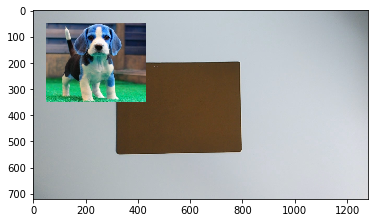

<Figure size 432x288 with 0 Axes>

In [76]:
import cv2
s_img = cv2.imread("../input/target.jpg", 1)
l_img = cv2.imread("../input/frames/scale/frame1.jpg")
x_offset=y_offset=50



l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
plt.imshow(l_img)
plt.show()
plt.clf()

## Experimenting to always do transform from frame 1

In [180]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.30




def getAffineTransform(original, transformed):
    """
    Finds the affine transformation based on pixel coordinates.
    This is all based on the linear equation provided in the Project 2 PDF
    :param original: array (M x 2) containing the coordinates in the original image - one coordinate [x,y] per row
    :param transformed: array (M x 2) containing the coordinates in the transformed image - one coordinate [x,y] per row
    :return: matrix A that defines the affine transformation
    """

    # checking dimensions
    assert (original.shape[1] == 2)
    assert (transformed.shape[1] == 2)
    assert (transformed.shape[0] == original.shape[0])

    # building the X matrix
    matches_count = original.shape[0]
    zeros = np.zeros((matches_count, 3))
    coordinates_with_1 = np.append(original, np.ones((matches_count, 1)), axis=1)
    x_left = np.column_stack((coordinates_with_1, zeros)).reshape(2 * matches_count, 3)
    x_right = np.column_stack((zeros, coordinates_with_1)).reshape(2 * matches_count, 3)
    x = np.column_stack((x_left, x_right)).astype(int)

    # building the Y matrix
    y = transformed.reshape((2 * matches_count, 1))

    # solving the system
    first_term = x.transpose().dot(x)
    second_term = x.transpose().dot(y)
    a = np.linalg.inv(first_term).dot(second_term)
    return a.reshape(2,3)


def alignImages(im1, im2):
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
    
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # add green circles on keypoints
#     for p in points1:
# cv.circle(im1, (p[0], p[1]), 5, (0,255,0), -1)
    corners = np.zeros((len(keypoints1), 2), dtype=np.float32)
    for i, p in enumerate(keypoints1):
        cv2.circle(im1, (int(p.pt[0]), int(p.pt[1])), 5, (0,255,0), -1)
        corners[i, :] = p.pt
    
#     corners.sort()
#     print('corners:')
#     print(corners)
        
    # Compute affine transformation matrix and Transform
    cols, rows = im2Gray.shape
    affine_transform = getAffineTransform(points1, points2)
    dst = cv2.warpAffine(im1, affine_transform, (rows, cols))

    # 190 330
    # 185 827
    # 547 831
    # 330 530
    
    # frame 1 
    global s_img, mask, target
    l_img = im1
    x_offset=330
    y_offset=190
#     s_img = cv2.warpAffine(s_img, affine_transform, (300, 400))
#     l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
#     plt.imshow(l_img)
#     plt.show()
#     plt.clf()
    
    # frame 2 - transform
#     l_img = im2

#     im1[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
    
    # this will only the binary mask
    frame = cv2.imread("../input/frames/rotate/frame1.jpg", cv2.IMREAD_COLOR)
    mask = np.zeros((frame.shape[0], frame.shape[1]), np.uint8)
    mask[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = 1

    # this will contain the target image
    s_img = cv2.imread("../input/target.jpg", 1)
    s_img = cv.resize(s_img, (500, 360), interpolation = cv.INTER_CUBIC)
    target = np.zeros((frame.shape[0], frame.shape[1], 3), np.uint8)
    target[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img

#     pasted = np.copy(mask)
#     pasted = cv2.bitwise_not(l_img, pasted, mask)
    mask = cv2.warpAffine(mask, affine_transform, (mask.shape[1], mask.shape[0]))
    target = cv2.warpAffine(target, affine_transform, (mask.shape[1], mask.shape[0]))
#     pasted = cv2.bitwise_not(im2, pasted, mask)
    copy_output = np.copy(im2)
    np.copyto(copy_output, target, where=mask[:, :, None].astype(bool))
    
#     plt.imshow(mask), plt.title('Mask'), plt.show(), plt.clf()
#     plt.imshow(copy_output), plt.title('Frame 2'), plt.show(), plt.clf()
    
    return copy_output


if __name__ == '__main__':
    FRAMES = 500
    for i in range(FRAMES):
        try:
            # Read reference image
            refFilename = "../input/frames/rotate/frame1.jpg"
            imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

            # Read image to be aligned
            imFilename = "../input/frames/rotate/frame"+str(i)+".jpg"
            im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

            # Registered image will be resotred in imReg. 
            # The estimated homography will be stored in h. 
            pasted = alignImages(imReference, im)

            # Write aligned image to disk. 
            outFilename = "rotate"+str(i)+".jpg"
            cv2.imwrite(outFilename, pasted)
            
        except:
            break
    
    height,width,layers=img[1].shape
    video = cv2.VideoWriter('rotate.avi',cv2.VideoWriter_fourcc(*"MJPG"), 30,(width,height))

    for i in range(FRAMES):
        video.write(cv2.imread('rotate'+ str(i)+'.jpg'))

    cv2.destroyAllWindows()
    video.release()
    print("FINISHED")
    
        # Print estimated homography
#         print("Estimated homography : \n",  h)

(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)
(2, 3)